# Mini project - Emotion and gender speech audio classification using CNN and NN

In [1]:
# All imports
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import librosa
import librosa.display

import sklearn as sk
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn.metrics as skmetric

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from IPython import display

# Set the seed value for experiment reproducibility
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)
sk.random.seed(seed)

In [2]:
# CONSTANTS
EMOTIONS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
GENDER = ['F', 'M']

### Helper functions

In [3]:
def genderNumToString(num):
    return GENDER[num]

def arrayGenderNumToString(data):
    res = []
    for d in data:
        res.append(genderNumToString(d))
    return np.array(res)

def emotionNumToString(num):
    return EMOTIONS[num]

def arrayEmotionNumToString(data):
    res = []
    for d in data:
        res.append(emotionNumToString(d))
    return np.array(res)

def plotAudio(data, genderLabel, emotionLabel, rows = 1, cols = 1, figsize=(16, 9), ylim=1):

    n = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i in range(n):
        if i>=n:
            break
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(data[i])
        label = genderNumToString(genderLabel[i]) + ' | ' + emotionNumToString(emotionLabel[i]) 
        ax.set_title(label)
        ax.set_ylim([-ylim, ylim])

    plt.show()

def plotTraningTestLossAcc(history, epochs):
    epochsRange = [i for i in range(epochs)]
    fig , ax = plt.subplots(1,2, figsize=(16,5))
    trainAcc = history.history['accuracy']
    trainLoss = history.history['loss']
    testAcc = history.history['val_accuracy']
    testLoss = history.history['val_loss']

    ax[0].plot(epochsRange , trainLoss , label = 'Training Loss')
    ax[0].plot(epochsRange , testLoss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochsRange , trainAcc , label = 'Training Accuracy')
    ax[1].plot(epochsRange , testAcc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylim((0, 1))
    plt.show()

## Load the data

In [4]:
datasetPath = 'audio_speech_actors_01-24'
sampleRate = 16000
sampleOffset = 1
sampleDuration = 2

data = []
genderLabel = []
emotionLabel = []

for actorPath in os.listdir(datasetPath):
    for audioFile in os.listdir(datasetPath + '/' + actorPath):
        y, sr = librosa.load(datasetPath + '/' + actorPath + '/' + audioFile, sr=sampleRate, offset=sampleOffset, duration=sampleDuration)
        y = np.pad(y, (0, sampleRate*sampleDuration - len(y)))
        data.append(y)
        
        fileName = audioFile.split('.')[0].split('-')
        genderLabel.append(int(fileName[-1]) % 2)
        emotionLabel.append(int(fileName[2])-1)


## Before preprocessing

### Shuffle
Shuffle/Permute the data and the labels the same way

In [5]:
shuffledData, shuffledGenderLabel, shuffledEmotionLabel = sk.utils.shuffle(data, genderLabel, emotionLabel)

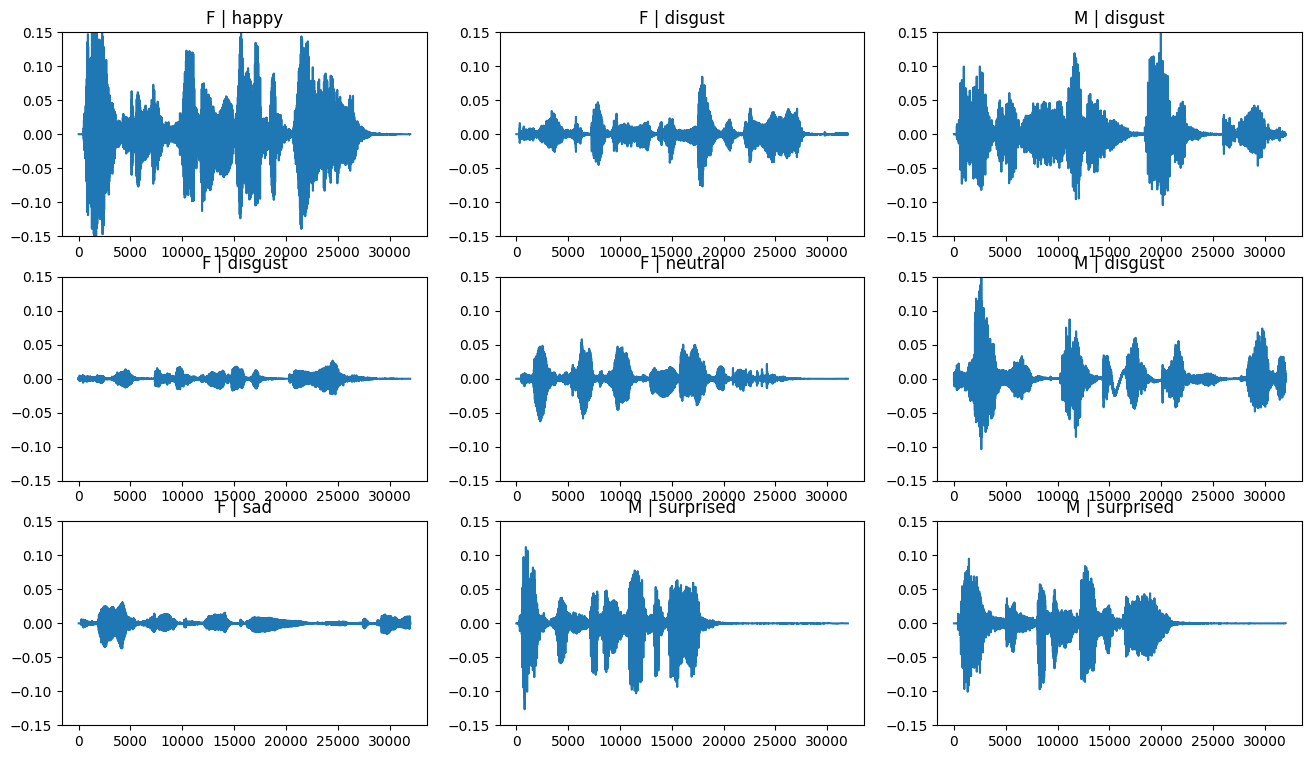

In [6]:
plotAudio(shuffledData, shuffledGenderLabel, shuffledEmotionLabel, ylim=.15, rows=3, cols=3)

## Preprocessing

### Pre-emphasis
To compensate the high-frequency section which is naturaly suppressed, especially because we have both male and female voices

In [7]:
preEmphasisData = []

for audio in shuffledData:
    preEmphasisData.append(librosa.effects.preemphasis(audio))

preEmphasisData = np.array(preEmphasisData, dtype=object)


### Normilization
Put the data in the range of -1 to 1


In [8]:
# def findMax(data):
#     max = 0
#     for audio in data:
#         for n in audio:
#             n = np.abs(n)
#             if(n > max):
#                 max = n
#     return max

# def normalize(x, max, axis=0):
#     return x / max
#     scaler = StandardScaler()
#     # featureData2 = np.expand_dims(np.expand_dims(featureData, axis=2), axis=2)
#     return scaler.fit_transform(x.reshape(-1, 1))
#     return sk.preprocessing.normalize(x.reshape(-1, 1))
#     return sk.preprocessing.minmax_scale(x, feature_range=(-1,1), axis=axis)

# normilizedData = []

# max = findMax(preEmphasisData)

# for audio in preEmphasisData:
#     normilizedData.append(normalize(audio.rolling(7).sum(), max))

# normilizedData = np.array(normilizedData, dtype=object)
    

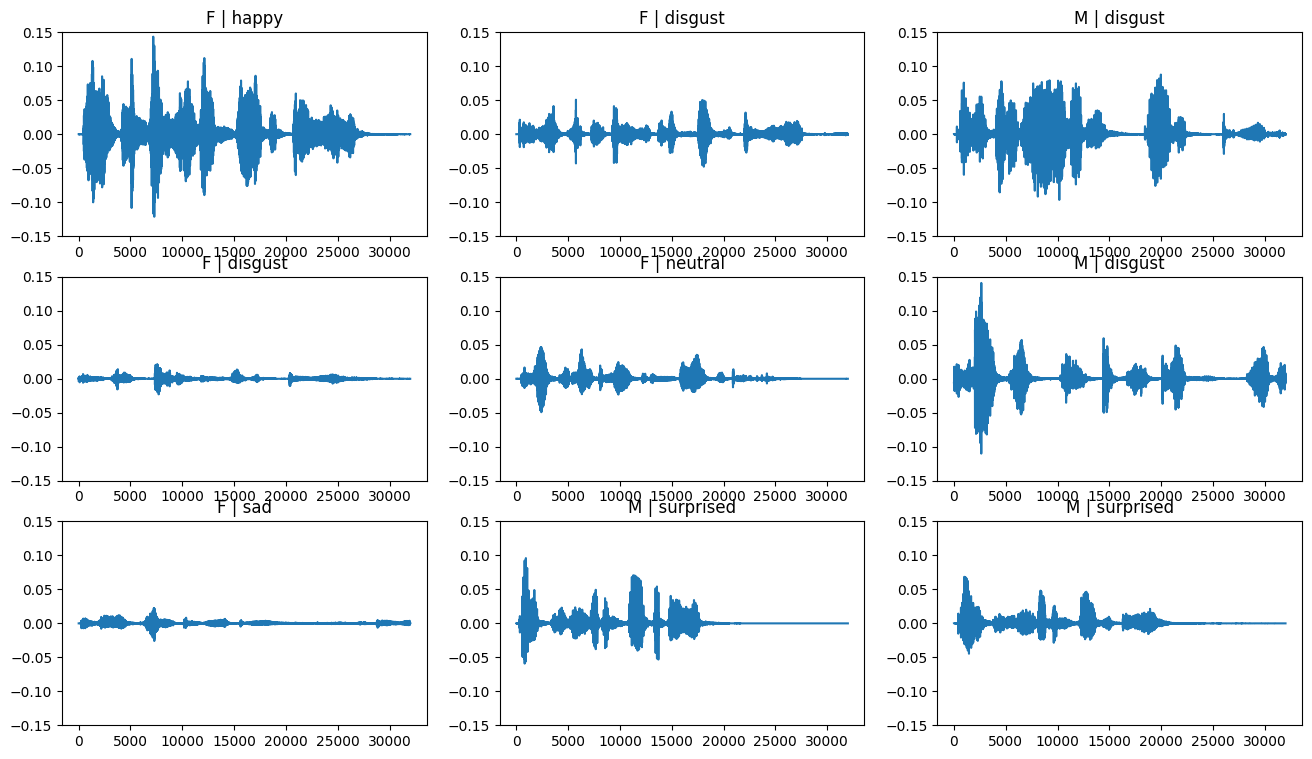

In [9]:
plotAudio(preEmphasisData, shuffledGenderLabel, shuffledEmotionLabel, ylim=0.15, rows=3, cols=3)

## Fearure Extraction

Extact features of all audio files to get better data for defining differences between the data and to make the neural networkss better and faster

* **Zero crossing rate:** Calculate the amout of times the singal crosses 0 on the x axis.
* **Mel-frequency cepstral coefficients:** This is coefficients that collectively make up an MFC, which are derived from a type of cepstrum of the audio.
* **Chroma feature analysis and synthesis:** Compute a chromagram from a waveform or power spectrogram.
* **Root Mean Squared:** Compute root-mean-square (RMS) value.
* **Mel-scaled Spectrogram:** Compute a mel-scaled spectrogram. A mel spectrogram logarithmically renders frequencies above a certain threshold.

In [10]:
featureData = []

for audio in preEmphasisData:
    audio = audio.astype('float32')

    # Zero crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y = audio).T, axis=0)

    # Mel-frequency cepstral coefficients
    mfcc = np.mean(librosa.feature.mfcc(y = audio, sr = sampleRate).T, axis=0)

    # Chroma feature analysis and synthesis
    stft = np.abs(librosa.stft(audio))
    cstft = np.mean(librosa.feature.chroma_stft(S = stft, sr = sampleRate).T, axis=0)

    # Root Mean Squared
    rms = np.mean(librosa.feature.rms(y = audio).T, axis=0)

    # Mel-scaled Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y = audio, sr = sampleRate).T, axis=0)

    featureData.append(np.concatenate((zcr, mfcc, cstft, rms, mel)))

featureData = np.array(featureData, dtype=object)
featureData.shape


(1440, 162)

## Normalize
Normalize the extracted features to make them coherent

In [11]:
scaler = StandardScaler()
featureData = scaler.fit_transform(featureData)
featureData = np.expand_dims(np.asarray(featureData).astype('float32'), axis=2)
featureData.shape

(1440, 162, 1)

## Encode
Encode the labels to one hot encoding for compatability with the neural networks

In [12]:
emotionEncoder = OneHotEncoder()
encodedEmotionLabel = emotionEncoder.fit_transform(np.array(shuffledEmotionLabel).reshape(-1,1)).toarray()

genderEncoder = OneHotEncoder()
encodedGenderLabel = genderEncoder.fit_transform(np.array(shuffledGenderLabel).reshape(-1,1)).toarray()

## Split the data
Split the data and the labels into train and test sets

In [13]:
length = len(featureData)
splitRatio = 0.8
split = int(length*splitRatio)

trainData = featureData[:split]
trainGenderLabel = encodedGenderLabel[:split]
trainEmotionLabel = encodedEmotionLabel[:split]

testData = featureData[split:]
testGenderLabel = encodedGenderLabel[split:]
testEmotionLabel = encodedEmotionLabel[split:]

In [14]:
trainData.shape, testData.shape, trainGenderLabel.shape, testGenderLabel.shape, trainEmotionLabel.shape, testEmotionLabel.shape

((1152, 162, 1), (288, 162, 1), (1152, 2), (288, 2), (1152, 8), (288, 8))

# Model creation, training and performance evaluation

## Emotion model - CNN

We use a CNN model for the emotion classificaion. Its a multi-class classification problem therefore convolution seamed to be a great choise for this. With some testing of parameters the relu function gave us the best result and using some dropout made the model not overfit itself. 60 epochs was suficient as the accuracy was not increasing enough and the loss of the validation data started to increase with 60+ epochs.

### Creation

In [15]:
emotionModel = Sequential()
# emotionModel.add(tf.keras.layers.InputLayer(input_shape=(trainData.shape[1], 1)))
# emotionModel.add(tf.keras.layers.LSTM(32))
# emotionModel.add(Flatten())
# emotionModel.add(Dense(32))

emotionModel.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(trainData.shape[1], 1)))
emotionModel.add(MaxPooling1D(pool_size=5, strides = 2))
# emotionModel.add(Dropout(0.2))
# emotionModel.add(Conv1D(32, kernel_size=5, activation='relu'))
# emotionModel.add(MaxPooling1D(pool_size=5, strides = 2))
emotionModel.add(Dropout(0.2))
# emotionModel.add(tf.keras.layers.LSTM(32))
emotionModel.add(Dense(64, activation='relu'))
emotionModel.add(Flatten())
emotionModel.add(Dense(32, activation='relu'))
emotionModel.add(Dropout(0.3))
emotionModel.add(Dense(8, activation='softmax'))

emotionModel.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

emotionModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 158, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 77, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 77, 128)           0         
                                                                 
 dense (Dense)               (None, 77, 64)            8256      
                                                                 
 flatten (Flatten)           (None, 4928)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                157728    
                                                        

### Training

In [16]:
emotionEpochs = 60
emotionHistory = emotionModel.fit(trainData, trainEmotionLabel, batch_size=32, epochs=emotionEpochs, validation_data=(testData, testEmotionLabel))

Epoch 1/60
36/36 [==============================] - 4s 25ms/step - loss: 1.9735 - accuracy: 0.2248 - val_loss: 1.8465 - val_accuracy: 0.2674
Epoch 2/60
36/36 [==============================] - 1s 17ms/step - loss: 1.8462 - accuracy: 0.2960 - val_loss: 1.7688 - val_accuracy: 0.3507
Epoch 3/60
36/36 [==============================] - 1s 16ms/step - loss: 1.7362 - accuracy: 0.3472 - val_loss: 1.6682 - val_accuracy: 0.3750
Epoch 4/60
36/36 [==============================] - 1s 16ms/step - loss: 1.6713 - accuracy: 0.3759 - val_loss: 1.6331 - val_accuracy: 0.3785
Epoch 5/60
36/36 [==============================] - 1s 17ms/step - loss: 1.5997 - accuracy: 0.4036 - val_loss: 1.5990 - val_accuracy: 0.4028
Epoch 6/60
36/36 [==============================] - 1s 16ms/step - loss: 1.5040 - accuracy: 0.4323 - val_loss: 1.5741 - val_accuracy: 0.4271
Epoch 7/60
36/36 [==============================] - 1s 16ms/step - loss: 1.4873 - accuracy: 0.4618 - val_loss: 1.5137 - val_accuracy: 0.4549
Epoch 8/60
36

### Performance evaluation

Plot the loss and accuracy in each epoch over time

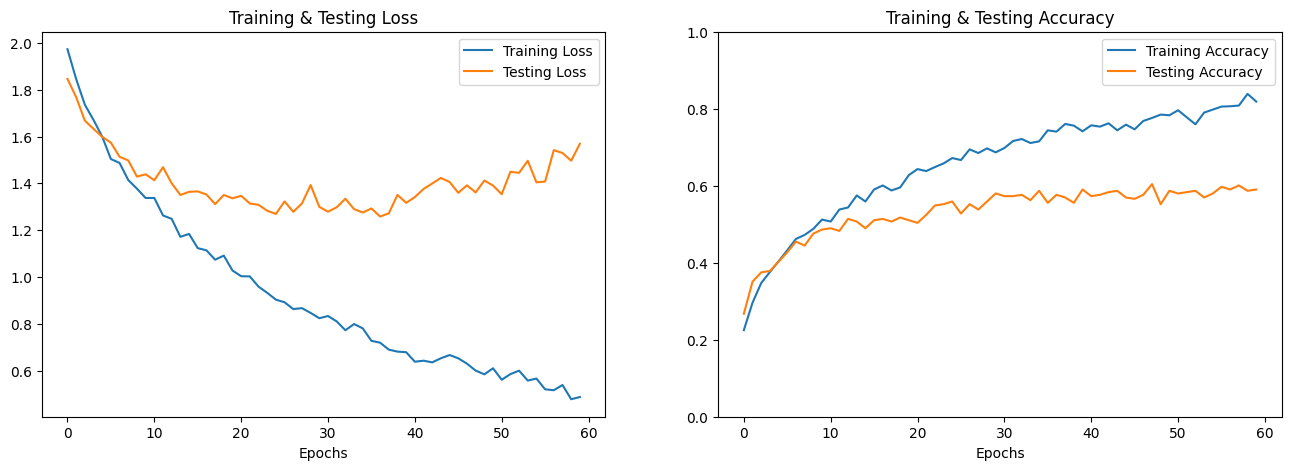

In [17]:
plotTraningTestLossAcc(emotionHistory, emotionEpochs)

Predict the labels of the test data then decode the predicted and real labels for confusion matrix

In [18]:
predTestEmotionLabelEncoded = emotionModel.predict(testData)

predTestEmotionLabel = emotionEncoder.inverse_transform(predTestEmotionLabelEncoded)
predTestEmotionLabel = predTestEmotionLabel.reshape(1, -1)[0]
testEmotionLabel = emotionEncoder.inverse_transform(testEmotionLabel)
testEmotionLabel = testEmotionLabel.reshape(1, -1)[0]

9/9 [==============================] - 0s 5ms/step


Plot the confusion matrix and print the classificaion report

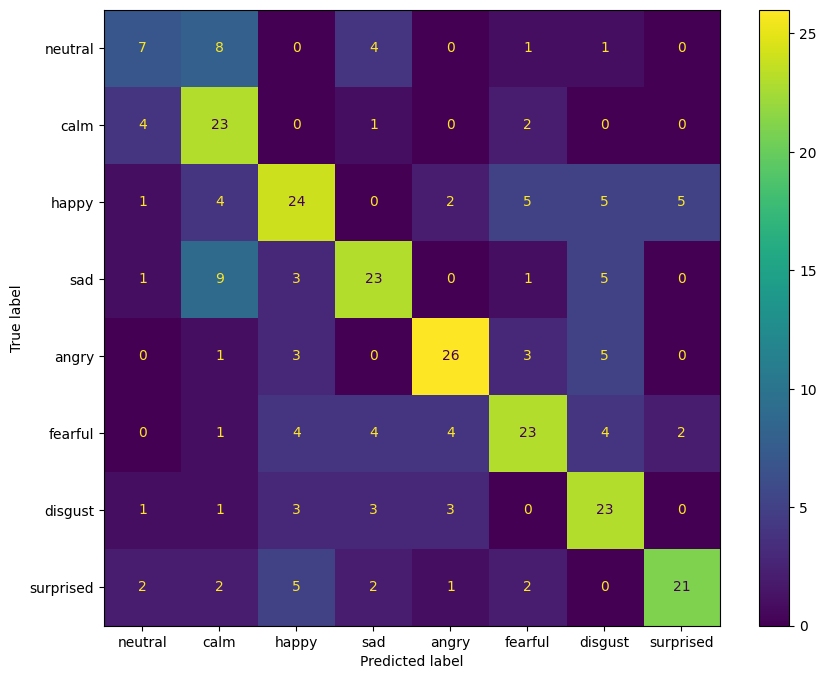

              precision    recall  f1-score   support

       angry       0.72      0.68      0.70        38
        calm       0.47      0.77      0.58        30
     disgust       0.53      0.68      0.60        34
     fearful       0.62      0.55      0.58        42
       happy       0.57      0.52      0.55        46
     neutral       0.44      0.33      0.38        21
         sad       0.62      0.55      0.58        42
   surprised       0.75      0.60      0.67        35

    accuracy                           0.59       288
   macro avg       0.59      0.58      0.58       288
weighted avg       0.60      0.59      0.59       288



In [19]:
matrix = skmetric.confusion_matrix(testEmotionLabel, predTestEmotionLabel)
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=EMOTIONS)
fig, ax = plt.subplots(figsize=(10,8))
display.plot(ax=ax)
plt.show()

print(skmetric.classification_report(arrayEmotionNumToString(testEmotionLabel), arrayEmotionNumToString(predTestEmotionLabel)))

### Conlcusion

* We can see that **angry**, **fearful**, **sad** and **surprised** all have a precision greater than 60% and that **angry** and **surprised** is over 70%. That **angry** and **surprised** is the ones with highest precision is not really surprising as these emotions differ to to the other emotions in a lot of ways like pitch, speed, etc.

* We also see that **neutral** is the worst predicted one and is often predicted as **calm**, which is also not surprising as some one takling naturaly may be recived as calm.

* And with an overall accuracy of 59% the model is definently better than just guessing (12.5%). Though some testing has been done to find good parameters and such the accracy could possibly be improved by extracting different, more or less features from the audio files or by using a diffenet model or different parameters.

## Gender model - NN

We use a NN model for the gender classificaion. Its a binary-classification problem therefore a normal neural network seamed to be a good enough choise for this. With some testing of parameters the tanh function gave us the best result and changing the loss function to the the mean-squared-error was also a good choise.

### Creation

In [20]:
genderModel = Sequential()
genderModel.add(tf.keras.layers.InputLayer(input_shape=(trainData.shape[1], 1)))
genderModel.add(Flatten())
genderModel.add(Dense(16, activation='tanh'))
genderModel.add(Dropout(0.2))
genderModel.add(Dense(2, activation='softmax'))

genderModel.compile(optimizer='adam', loss = "mean_squared_error", metrics=['accuracy'])

genderModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 162)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                2608      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 2,642
Trainable params: 2,642
Non-trainable params: 0
_________________________________________________________________


### Training

In [21]:
genderEpochs = 20
genderHistory = genderModel.fit(trainData, trainGenderLabel, batch_size=32, epochs=genderEpochs, validation_data=(testData, testGenderLabel))

Epoch 1/20
36/36 [==============================] - 1s 5ms/step - loss: 0.1615 - accuracy: 0.7743 - val_loss: 0.0700 - val_accuracy: 0.9444
Epoch 2/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9288 - val_loss: 0.0392 - val_accuracy: 0.9653
Epoch 3/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0390 - accuracy: 0.9575 - val_loss: 0.0266 - val_accuracy: 0.9757
Epoch 4/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9618 - val_loss: 0.0213 - val_accuracy: 0.9792
Epoch 5/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9740 - val_loss: 0.0187 - val_accuracy: 0.9826
Epoch 6/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9792 - val_loss: 0.0153 - val_accuracy: 0.9826
Epoch 7/20
36/36 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9896 - val_loss: 0.0118 - val_accuracy: 0.9861
Epoch 8/20
36/36 [==

### Performance evaluation

Plot the loss and accuracy of each epoch

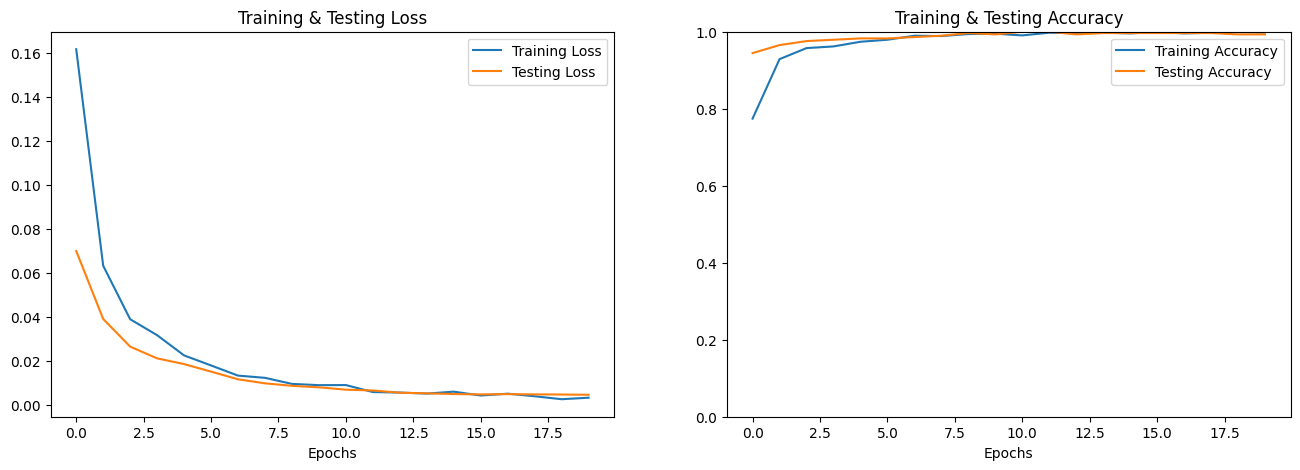

In [22]:
plotTraningTestLossAcc(genderHistory, genderEpochs)

Predict the labels of the test data then decode the predicted and real labels for confusion matrix

In [23]:
predTestGenderLabelEncoded = genderModel.predict(testData)

predTestGenderLabel = genderEncoder.inverse_transform(predTestGenderLabelEncoded)
predTestGenderLabel = predTestGenderLabel.reshape(1, -1)[0]
testGenderLabel = genderEncoder.inverse_transform(testGenderLabel)
testGenderLabel = testGenderLabel.reshape(1, -1)[0]

9/9 [==============================] - 0s 1ms/step


Plot the confusion matrix and print the classificaion report

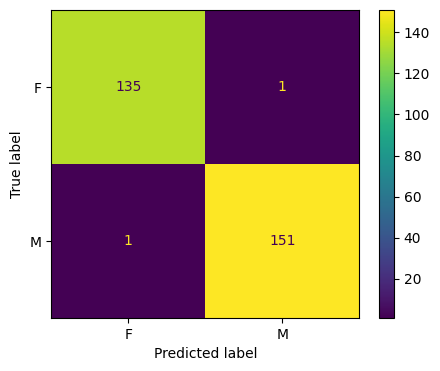

              precision    recall  f1-score   support

           F       0.99      0.99      0.99       136
           M       0.99      0.99      0.99       152

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



In [24]:
matrix = skmetric.confusion_matrix(testGenderLabel, predTestGenderLabel)
display = skmetric.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=GENDER)
fig, ax = plt.subplots(figsize=(5,4))
display.plot(ax=ax)
plt.show()

print(skmetric.classification_report(arrayGenderNumToString(testGenderLabel), arrayGenderNumToString(predTestGenderLabel)))

### Conlcusion

* With an overall accuracy of 99% we can see that using a simple normal neural network was definitely enough to almost pefectly predict wether the audio file was from a male or female voice actor